# 자율주행 보조 시스템 만들기

object detection을 통해 다른 차나 사람이 있으면 멈추는 간단한 자율주행 보조 시스템을 만들어보자.

# 1. 데이터셋 불러오기

`tensorflow_datasets`에서 제공하는 KITTI 데이터셋을 사용해보자. 이는 자율주행을 위한 데이터셋으로 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있다.

[cvlibs에서 제공하는 KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/)

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '/content/drive/MyDrive/aiffel_dataset/GD08_object_detection/data'

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

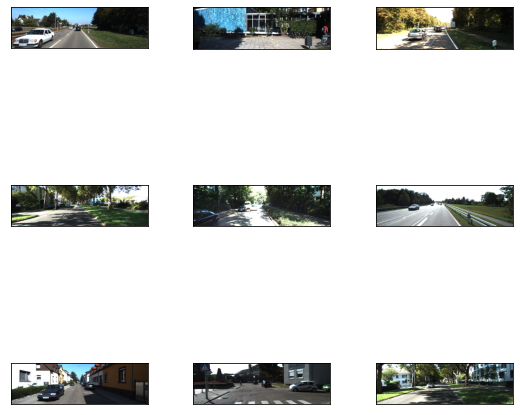

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

# 2. 데이터 확인하기

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-1.66,  0.25, -2.79, -0.35, -2.72, -2.73,  0.57,  0.7 , -0.73,
       -0.93], dtype=float32)>, 'bbox': <tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[0.42536   , 0.5121417 , 0.51178664, 0.54883254],
       [0.39682665, 0.28924316, 0.52290666, 0.3950644 ],
       [0.32474667, 0.1942029 , 0.50616   , 0.34513688],
       [0.33773333, 0.6083736 , 0.5160533 , 0.75545895],
       [0.29904   , 0.13387279, 0.5044    , 0.3169807 ],
       [0.23946667, 0.05114332, 0.54770666, 0.29162642],
       [0.16064   , 0.        , 0.49984   , 0.26651368],
       [0.02730667, 0.        , 0.4808    , 0.21529791],
       [0.07216   , 0.80185187, 0.51338667, 0.99919486],
       [0.00266667, 0.92387277, 0.47234666, 0.99919486]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[1.32, 1.63, 4.1 ],
       [1.58, 1.56, 4.25],

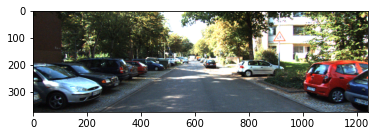

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

KITTI 데이터셋의 정보를 확인해보면 바운딩 박스가 이렇게 나와있다.

```
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
```

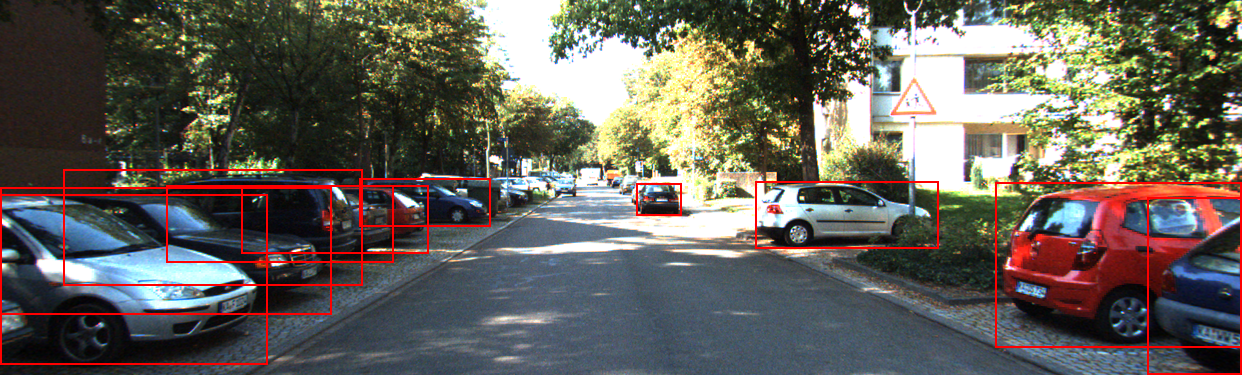

In [6]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

# 3. 데이터 준비

### 데이터 파이프라인 만들기
주어진 KITTI 데이터를 학습에 맞는 형태로 바꿔야 한다.    
이때 사용할 데이터 파이프라인을 구축하자.

1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계 수정   
[x_min, y_min, x_max, y_max] -> [x_min, y_min, width, height]

In [7]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [8]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

이미지의 크기를 바꿀 때 고려할 점이 있다.   
이미지의 비율은 유지되어야 하고, 이미지의 최대, 최소 크기도 제한해야한다. 이미지의 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 되도록 만들어야한다.

예를들어 600x720 크기의 이미지가 있다면 800x960 크기로 바꿀 수 있다. 여기에 `stride`를 128로 놓고 패딩을 더하면 896x1024 크기의 이미지로 모델에 입력하겠다는 이야기다.(패딩으로 검정 테두리가 생긴다)

실제 입력할 이미지를 어떻게 바꿀지는 `min_side`, `max_side`, `min_side_range`, `stride` 등에 의해 결정된다. 학습이 완료된 모델을 사용할 때 입력할 이미지를 다양한 크기로 바꿀 필요가 없어 분기처리를 해준다.

In [9]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

In [10]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [11]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

### 인코딩
One stage detector에서는 anchor box라는 정해진 위치, 크기, 비율 중에 하나로 물체의 위치가 결정된다. 그래서 기본적으로 anchor box를 생성해야한다.   
anchor box로 생성되는건 물체 위치 후보라고 생각하면 된다.

RetinaNet에서는 FPN을 사용하기 때문에 anchor box가 더 많이 필요하다. FPN의 각 층마다 anchor box가 필요하기 때문이다. RetinaNet의 FPN에서 pyramid level은 개수가 미리 약속되어 있기 떄문에 각 level에서 만들어지는 anchor box도 약속되어 있다.

In [12]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

입력할 데이터를 anchor box에 맞게 변형해줘야 한다.

또한 anchor box의 IoU가 높은지, 낮은지에 따라 anchor box가 정답인지 오답인지 체크할 수 있다.

In [13]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

실제 라벨을 anchor box에 맞춰는 클래스를 만들어보자. `compute_iou` 함수를 이용해서 IoU를 구하고, 그걸 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정해준다. 그리고 그 anchor box와 실제 bounding box의 미세한 차이를 계산한다.   
상하좌우 차이, 가로세로 크기의 차이를 기록하는데 가로세로는 로그를 사용해서 기록한다.

이 과정에서 variance가 등장하는데 관례적으로 anchor box를 사용할 때 등장한다.   
그리고 상하좌우의 차이에는 0.1, 가로세로 크기 차이에는 0.2를 사용한다.   
이와 관련해서 통계적 추정치를 계산할 떄 분산으로 나눠주는 것이라는 의견도 있다.

이 과정은 데이터를 훈련이 가능한 형식으로 encode하는것 같으니 LabelEncoder라는 이름으로 클래스를 만들자.

IoU가 0.5보다 높으면 물체, 0.4보다 낮으면 배경이다.

In [14]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

# 4. 모델 만들기

이번에 사용할 모델은 RetinaNet이다.   

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 갖고 있다. 이를 해결하기 위해 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network)를 적용한 네트워크를 사용한다.

### Feature Pyramid
FPN과 완전 동일하게 사용하지 않고 약간 수정했다.

In [15]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

Object Detection의 라벨은 class와 box로 이루어지므로 각각 추론하는 부분이 필요하다. 그것을 head라고 부르기도 한다.   
Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layer가 추출되고 나면 그 feature들을 바탕으로 class와 box를 예상한다.   
class와 box가 모두 맞을 수도, 하나만 맞을 수도, 다 틀릴 수도 있다.   
class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다는게 중요함을 인지하자.

그래서 각각의 head를 만들어주자. head는 유사한 형태로 만들 수 있으니 `build_head`라는 함수를 만들어 두 번 호출하자.

In [16]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

RetinaNet의 backbone은 ResNet50이다. FPN에 이용할 수 있게 중간 레이어도 output으로 연결해주자.

In [17]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

RetinaNet을 완성해보자.   
backbone + FPN + classification용 head + box용 head 형태이다.

In [18]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

### Loss

RetinaNet에서는 Focal loss를 사용하는데, Box regression에는 사용하지 않고 classification loss를 계산하는데만 사용한다. box regression은 smooth L1 loss를 사용한다.

Smooth L1 Loss를 사용하는 Box Regression은 `delta`를 기준으로 계산이 달라지고, Focal Loss를 사용하는 Classification은 `alpha`, `gamma`를 사용해서 물체일 때와 배경일 때 식이 달라진다.

In [19]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

# 5. 모델 학습

In [20]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 0s 0us/step


Learning Rate를 만들어보자. 논문은 8개의 GPU를 사용했는데, 환경이 맞지 않아 새롭게 바꿔보자.   
Optimizer는 SGD를 사용한다.

In [21]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

전처리를 위한 파이프라인도 만들자.

In [22]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

학습 시간이 상당히 오래 걸리므로 미리 저장된 모델 가중치를 가져와서 사용하자.

# 6. 결과 확인하기

In [23]:
model_dir = '/content/drive/MyDrive/aiffel_dataset/GD08_object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

모델의 추론 결과를 처리할 함수를 레이어 형식으로 만들어 준다.    
논문에서 1000개의 후보를 골라 처리했지만 우리는 100개만 처리해보자.

0.05보다 높은 box 1000개를 골라 0.5 NMS를 진행한다.

NMS(Non-Max Suppression)은 직접 구현하지 않고 `tf.image.combined_non_max_suppression`을 사용했다.   

In [24]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

추론 가능한 모델을 조립해보자.

In [25]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

추런 결과를 시각화하는 함수를 만들자.

In [26]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box


        # 상하 반전 추가
        y1 = image.shape[0] - y1
        y2 = image.shape[0] - y2

        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y2, # y1 -> y2로 변경
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

추론할때 입력 데이터를 전처리하기 위한 함수를 만들어보자.

학습을 위한 전처리와 추론을 위한 전처리가 달라 따로 작성했다. 추론을 위한 전처리가 훨씬 간단하다.

In [27]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

결과를 확인해보자!

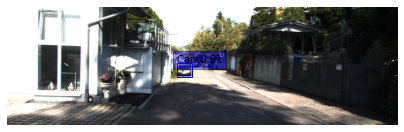

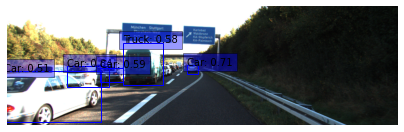

In [28]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# 7. 자율주행 보조 시스템 만들기

위에서 만든 모델로 아래의 조건을 만족하는 함수를 만들어보자.

- 입력으로 이미지 경로를 받는다
- 정지 조건에 맞는 경우 "Stop", 아닌 경우 "Go"를 반환한다.
- 조건은 사람이 한 명 이상 있는 경우, 차량의 크기(width or height)가 300px 이상인 경우이다.

In [30]:
stop_img_path = '/content/drive/MyDrive/aiffel_dataset/GD08_object_detection/data/stop_1.png'
go_img_path = '/content/drive/MyDrive/aiffel_dataset/GD08_object_detection/data/go_1.png'

def self_drive_assist(img_path, size_limit=300):
    return "Stop"
    return "Go"


print(self_drive_assist(stop_img_path))
print(self_drive_assist(go_img_path))

Stop
Stop


# 8. 자율주행 보조 시스템 평가하기

`test_system()`을 통해 위에서 만든 함수를 평가해보자.   
10장에 대해 Go와 Stop을 맞게 반환하는지 평가하고 100점 만점으로 평가해보자.

In [ ]:
def test_system(func):
    work_dir = '/content/drive/MyDrive/aiffel_dataset/GD08_object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)